# Time Series of Player Scores

The purpose of this notebook is to write a function that will allow us to plot the time series of player scores for any given game. To do this, we use NumPy arrays to store each player's score at every point in the game. We import the clues dataset so we can calculate each player's score after every question, and the games dataset to fill in each contestant's final score (since Final Jeopardy wager is not in the clues dataset).

In [26]:
#Import packages and read datasets
#We filter warnings because the function returns the warning:
# SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
# Since this didn't affect the end results, I opted to ignore the warning
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
os.chdir('C:\\Users\\mhous\\scrap\\JeopardyProject')
clues = pd.read_csv('clues.csv')
games = pd.read_csv('games_clean.csv')

In [50]:
def score_timeseries(show_number, return_data = False):
    # Filter main datasets to include just the necessary columns
    FJ_data = games[['show_number', 'contestant_1', 'contestant_2', 'returning_champion', 'c_1_score_F', 'c_2_score_F', 'rc_score_F']]
    clues_data = clues[['show_number', 'value', 'round', 'order_number', 'correct', 'incorrect']]
    
    #Filter main datasets for desired show number
    FJ_game = FJ_data[FJ_data['show_number'] == show_number]
    df = clues_data[clues_data['show_number'] == show_number]
    
    # Clean the clues data
    # Remove the indicators for daily double or Final Jeopardy in the value column
    df.loc[:, 'value'] = df.loc[:, 'value'].replace('[DD$,:FJ]', '', regex=True)
    
    # Drop the Final Jeopardy row
    df = df.drop([df.index.max()], axis=0)
    
    # Convert column types to int
    df['value'] = df['value'].astype(int)
    df['order_number'] = df['order_number'].astype(int)
    
    # Replace NaN with an empty string
    df = df.fillna('')
    
    #Populate the contestants list in specific order (contestant_1, contestant_2, returning_champion)
    contestants = [FJ_game['contestant_1'].iloc[0].split(' ')[0], FJ_game['contestant_2'].iloc[0].split(' ')[0], FJ_game['returning_champion'].iloc[0].split(' ')[0]]
    
    #Initialize empty NumPy array
    contestants_array = np.zeros((3, len(df) + 1))
    
    #Subset data for the Jeopardy round
    J_round = df[df['round'] == 'J']
    
    #First for loop populates each contestant's array
    for contestant in range(3):
        # Second for loop tests whether the contestant is in the 'correct' or 'incorrect' column
        for i in J_round['order_number'].sort_values():
            # Need special logic for case when i == 1 
            if i == 1:
                # If contestant is in 'correct' column
                if contestants[contestant] in J_round[J_round['order_number'] == i]['correct'].iloc[0]:
                    # Add the question's value to the contestant's array
                    contestants_array[contestant][i-1] = J_round[J_round['order_number'] == i]['value'].iloc[0]
                # If contestant is in 'incorrect' columns
                elif contestants[contestant] in J_round[J_round['order_number'] == i]['incorrect'].iloc[0]:
                    # Subtract the question's value to the contestant's array 
                    contestants_array[contestant][i-1] = -J_round[J_round['order_number'] == i]['value'].iloc[0]
            # Rest of the code blocks follow the logic in the above two if statements
            else:
                if contestants[contestant] in J_round[J_round['order_number'] == i]['correct'].iloc[0]:
                    contestants_array[contestant][i-1] = contestants_array[contestant][i-2] + J_round[J_round['order_number'] == i]['value'].iloc[0]
                elif contestants[contestant] in J_round[J_round['order_number'] == i]['incorrect'].iloc[0]:
                    contestants_array[contestant][i-1] = contestants_array[contestant][i-2] - J_round[J_round['order_number'] == i]['value'].iloc[0] 
                # If name is not in 'correct' or 'incorrect', then score remains the same
                else:
                    contestants_array[contestant][i-1] = contestants_array[contestant][i-2]
    
    #Find how many questions were asked in Jeopardy round so index picks up in the correct place
    max_J = J_round['order_number'].max()
    
    # Repeat above process but for the Double Jeopardy round
    DJ_round = df[df['round'] == 'DJ']
    for contestant in range(3):
        for i in DJ_round['order_number'].sort_values():
            if contestants[contestant] in DJ_round[DJ_round['order_number'] == i]['correct'].iloc[0]:
                contestants_array[contestant][max_J + i-1] = contestants_array[contestant][max_J + i-2] + DJ_round[DJ_round['order_number'] == i]['value'].iloc[0] 
            elif contestants[contestant] in DJ_round[DJ_round['order_number'] == i]['incorrect'].iloc[0]:
                contestants_array[contestant][max_J + i-1] = contestants_array[contestant][max_J + i-2] - DJ_round[DJ_round['order_number'] == i]['value'].iloc[0] 
            else:
                contestants_array[contestant][max_J + i-1] = contestants_array[contestant][max_J + i-2]
    
    # Modify format of FJ_game so it can be used in for loop to input each contestant's final score
    FJ_game = FJ_game.iloc[0]
    
    # For each contestant, update their last value in the array to their final score found in FJ_game
    for i in range(3):
        contestants_array[i][-1] = FJ_game[i+4]  
    
    # Plot findings
    fig, ax = plt.subplots(figsize=(16,8))
    for i in range(3):
        plt.plot(contestants_array[i])
        plt.legend((contestants[0], contestants[1], contestants[2]))
        plt.ylabel('Score')
        plt.xlabel('Question Number')
        plt.title('Time Series of Player Scores in Show Number ' + str(show_number), loc='left')
    
    if return_data == True:
        return contestants_array, contestants

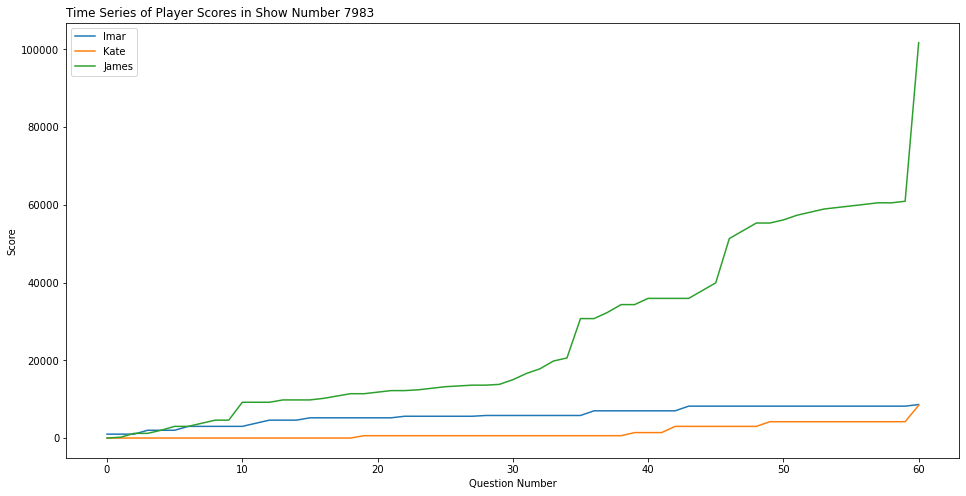

In [52]:
show_7983_score_array, show_7983_contestants = score_timeseries(7983, return_data = True)

In [55]:
# Order of scores always goes contestant 1, contestant 2, returning champion
print(show_7983_contestants)
print(show_7983_score_array)

['Imar', 'Kate', 'James']
[[  1000.   1000.   1000.   2000.   2000.   2000.   3000.   3000.   3000.
    3000.   3000.   3800.   4600.   4600.   4600.   5200.   5200.   5200.
    5200.   5200.   5200.   5200.   5600.   5600.   5600.   5600.   5600.
    5600.   5800.   5800.   5800.   5800.   5800.   5800.   5800.   5800.
    7000.   7000.   7000.   7000.   7000.   7000.   7000.   8200.   8200.
    8200.   8200.   8200.   8200.   8200.   8200.   8200.   8200.   8200.
    8200.   8200.   8200.   8200.   8200.   8200.   8612.]
 [     0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.    600.    600.    600.    600.    600.    600.    600.    600.
     600.    600.    600.    600.    600.    600.    600.    600.    600.
     600.    600.    600.   1400.   1400.   1400.   3000.   3000.   3000.
    3000.   3000.   3000.   3000.   4200.   4200.   4200.   4200.   4200.
    4200.   4200.   4200.  

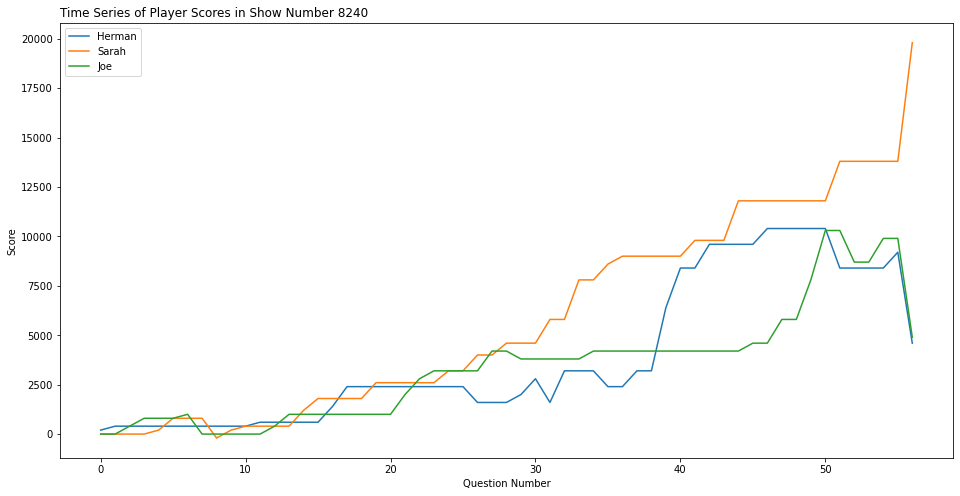

In [24]:
score_timeseries(8240)

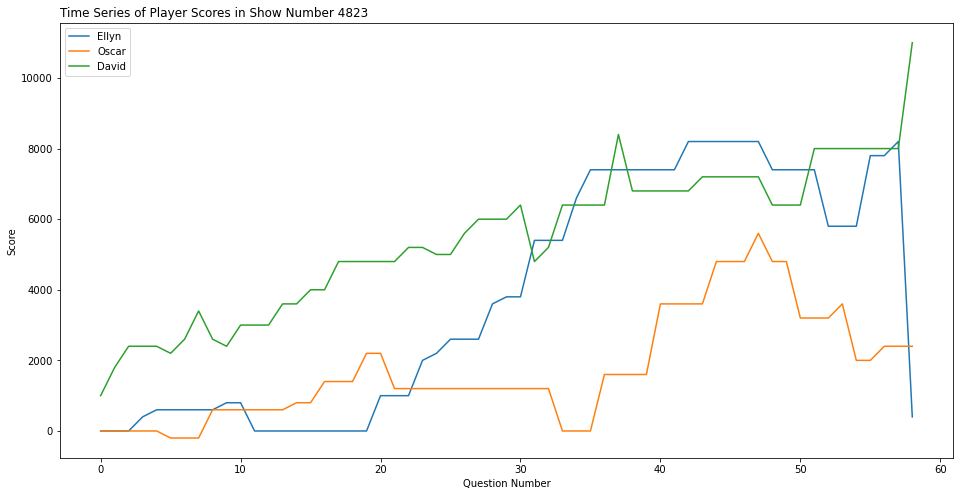

In [25]:
score_timeseries(4823)